# MNIST Problem

## Packages and Data Set

### Import Packages

In [36]:
# Numeric computing
import numpy as np
import random as rnd
# Importing data sets
import os
from numpy import genfromtxt
# Graphing and images
import matplotlib.pyplot as plt
%matplotlib inline
# Inputting latex
from IPython.display import display, Math, Latex
# Package for timing
import time

## Loading the MNIST Dataset

In [32]:
dataTrain = genfromtxt('MNIST/train.csv', delimiter=',')
dataTest = genfromtxt('MNIST/test.csv',delimiter=',')
# Splits data into [x_i , y_i] 
def dataSplit(data):
    return [[data[i][1:],data[i][0]] for i in range(1,len(data))]
trainMNIST = dataSplit(dataTrain)
testMNIST = dataSplit(dataTest)

## Visual of Dimension Reduction

[[   0.      0.      0.      0.      0.      0.      0.  ]
 [   0.      0.      0.     80.25  129.5     0.      0.  ]
 [   0.      0.      2.75  252.5   241.75   16.      0.  ]
 [   0.      0.    234.75   74.75    0.    211.25    0.  ]
 [   0.      0.    252.      0.      0.    252.5     0.  ]
 [   0.      0.    252.     66.25  200.     10.5     0.  ]
 [   0.      0.      0.      0.      0.      0.      0.  ]]


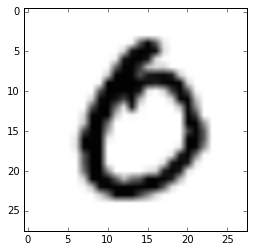

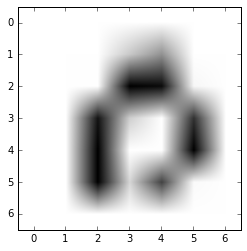

In [39]:
testImg = np.reshape(trainMNIST[200][0],(28,28))
imgReduced = np.zeros((7,7))
for i in range(len(imgReduced)):
    dataAvg = [(testImg[4*i][4*j] + testImg[4*i+1][4*j] + testImg[4*i][4*j+1] + \
               testImg[4*i+1][4*j+1]) / 4 for j in range(len(imgReduced[0]))]
    imgReduced[i] = dataAvg
print imgReduced

plt.imshow(testImg,cmap='Greys'); plt.show()
plt.imshow(imgReduced,cmap='Greys'); plt.show()

## Defining Functions

### Normalizing Data

In [22]:
# xNorm normalises the data to between -1 and 1
def dimensionReduction(data, newSize):
    xData_ = []; yData = []
    for x in range(len(data)):
        img = np.reshape(data[x][0],(28,28))
        imgReduced = np.zeros((7,7))
        for i in range(len(imgReduced)):
            dataAvg = [(img[4*i][4*j] + img[4*i+1][4*j] + img[4*i][4*j+1] + 
                        img[4*i+1][4*j+1]) / 4 for j in range(len(imgReduced[0]))]
            imgReduced[i] = dataAvg
        imgReduced_ = np.reshape(imgReduced,(1,49))[0]
        xData_ += [imgReduced_]
        yData += [data[x][1]]
        condIndex = np.random.choice(len(xData_),newSize)
    xDataCond = xData_[condIndex]
    yDataCond = yData[condIndex]
    return xDataCond, yDataCond

def xNorm(data):
    data_ = np.transpose(data)
    for i in range(len(data_)):
        max_ = max(data_[i]); min_ = min(data_[i])
        if (max_ - min_) == 0:
            data_[i] = -1
        else:
            data_[i] = [2*float(data_[i][j] - min_)/float(max_ - min_) - 1 \
                    for j in range(len(data_[i]))]
    return np.transpose(data_)

def yNorm(data):
    dataDim = len(data)
    yData = np.zeros((dataDim,max(data)+1))
    for i in range(dataDim):
        yData[i][data[i]-1] = 1
    return yData

### RBF Functions

In [ ]:
# r calculates the Euclidean Distance between vectors
def r(x,centre):
    if isinstance(x,float):
        return abs(x - centre)
    else:
        return np.sqrt(sum([(x[i]-centre[i])**2 for i in range(len(x))]))

# Scaling Parameter
def sigma(data,centre):
    m = len(data)
    return float(1)/float(m)*sum([r(data[i], centre) for i in range(m)])

# Calculates beta for the required activaion function
def betaCalc(data, centres):
    beta = np.zeros(len(centres))
    for i in range(len(centres)):
        sigma_ = sigma(data, centres[i])
        beta[i] = float(1) / float(2*sigma_**2)
    return beta

# Gaussian activation function
def hGauss(x, centre, beta):
    return np.exp(-beta*r(x,centre)**2)

# Ricker Wavelet activation function
def hRickerWavelet(x, centre, beta):
    return (1 - r(x,centre)**2)*np.exp(-beta*r(x,centre)**2/2)

# Plotting Examples of both activation functions
xExVals = np.linspace(-5,5,1000)
yExGaussVals = [hGauss(x,0,1) for x in xExVals]
yExRWVals = [hRickerWavelet(x, 0, 1) for x in xExVals]
print("The two RBF activation functions are")
display(Math(r'hGauss(r) = e^{-\beta r^2}'))
plt.plot(xExVals, yExGaussVals); plt.show()
display(Math(r'hRickerWavelet(r) = (1-r)e^{\frac{-\beta r^2}{2}}'))
plt.plot(xExVals, yExRWVals); plt.show()

### RBF Network

In [ ]:
# Complete RBF Network
def f(x,beta,w,centres, actFunct):
    if actFunct == "RW":
        h = hRickerWavelet
    else:
        h = hGauss
    F = np.zeros(len(w))
    for j in range(len(F)):
        for i in range(len(centres)):
            F[j] += w[j][i]*h(x, centres[i], beta[i])
    return F

# Classification function
# classFunct([1.5 32 5 2 7]) --> [0 1 0 0 0]
def classFunct(F):
    y_ = np.zeros(len(F))
    y_[np.argmax(F)] = 1
    return y_

## K-Means Clustering

### Defining K-Means

In [ ]:
# Euclidean Distance Measure
def dist(point1, point2):
    n = 0
    if isinstance(point1, int):
        n = abs(point2 - point1)
    else:
        for i in range(len(point1)): 
            n += abs(point2[i] - point1[i])
    return n

# Randomly assigns the data into n separate clusters at initiation
def initKMeans(data,dim):
    clusters = [[] for _ in range (dim)]
    dataIndex = range(len(data))
    dataIndex = sorted(dataIndex, key=lambda k:rnd.random())
    split = int(round(len(data)/dim)); n = 0
    for i in range(len(clusters)):
        clusters[i] = [data[j] for j in dataIndex[n:n+split]]
        n += split
    dif = len(data) - n
    clusters[-1] += [data[j] for j in dataIndex[-dif:]]
    return clusters

# Updates the centres of the clusters after every iteration
def kMeanCentUpdate(clusters,data):
    centres = [[] for _ in range(len(clusters))]
    for i in range(len(clusters)):
        if isinstance(data[0], int):
            centres[i] =  np.mean(clusters[i])
        elif len(clusters[i]) == 0:
            centres[i] = [[0] for _ in range(len(data[0]))]
        else:
            centres[i] = [[] for _ in range(len(data[0]))]
            for j in range(len(centres[i])):
                targetArray = [clusters[i][x][j] for x in range(len(clusters[i]))]
                centres[i][j] = np.mean(targetArray)
    return centres

# Updates the data, placing each data point in closest nearest cluster
def kMeanUpdate(clusters, centres):
    nClust = [[] for _ in range(len(clusters))]
    for i in range(len(clusters)):
        for j in range(len(clusters[i])):
            distArray = [dist(clusters[i][j], centres[x]) for x in range(len(centres))]
            optCluster = np.argmin(distArray)
            nClust[optCluster] += [clusters[i][j]]
    return nClust

# Complete K-Means algorithm
def kMeans(data, dim):
    clusters = initKMeans(data,dim) 
    oldCentres = None; centres = 0;
    n = 0
    while centres != oldCentres and n < 20:
        oldCentres = centres
        centres = kMeanCentUpdate(clusters,data) 
        clusters = kMeanUpdate(clusters, centres)
        n += 1
    return clusters, centres

## Network Training

### Loss Functions

In [30]:
print( "The two loss functions we will look at are")
display(Math(r'loss(x) = \frac{1}{m}\Bigg(\sum_{i=1}^{m} \bigg({\begin{cases}{0}& '\
             +r'\text{if }f(x^i) = y^i\\{1} & \text{else}\\\end{cases}}\bigg)\Bigg)'))
display(Math(r'logLoss(x) = \frac{1}{m}(\sum_{i=1}^{m}y^{i}log(f(x^{i})) + ' \
             + '(1-y^{i})log(1-f(x^i))'))

def loss(w, beta, centres, trainData, trainTarget,actFunct):
    cost = 0
    for i in range(len(trainData)):
        cost += sum([abs(classFunct(f(trainData[i], beta, w, centres,actFunct))[j] - \
                         trainTarget[i][j]) for j in range(len(trainTarget[i]))])
    return float(cost)/float(2*len(trainData))

def logLoss(w, beta, centres, trainData, trainTarget,actFunct):
    cost = 0
    for i in range(len(trainData)):
        cost += abs(sum([(trainTarget[i][j]*np.log(f(trainData[i],beta,w,centres,
                                                     actFunct)[j]) + \
                 (1 - trainTarget[i][j])* \
                          np.log(f(trainData[i],beta,w,centres,actFunct)[j])) \
                 for j in range(len(trainTarget[i]))]))
    return float(cost) / float(len(trainData))

The two loss functions we will look at are


<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Gradient Descent Function

In [ ]:
def gradDescent(weighting, beta, centres, trainData, targetData, learnRate, actFunct):
    if actFunct == "RW":
        h = hRickerWavelet
    else:
        h = hGauss
    wGrad = np.zeros((len(weighting),len(weighting[0])))
    for point in range(len(trainData)):
        F = f(trainData[point],beta,weighting,centres,actFunct)
        Y = targetData[point]
        diff = [tar - pred for pred,tar in zip(F,Y)]
        for i in range(len(wGrad)):
            for j in range(len(wGrad[1])):
                wGrad[i][j] += -h(trainData[point], centres[j], beta[j])*diff[i]
    w_ = np.zeros((len(weighting),len(weighting[1])))
    for i in range(len(weighting)):
        w_[i] = [origW - learnRate*wIter for origW,wIter in zip(weighting[i],wGrad[i])]
    return w_

In [ ]:
def gradDescentM(weighting, beta, centres, trainData, targetData, learnRate, eps, \
                 vList, actFunct):
    if actFunct == "RW":
        h = hRickerWavelet
    else:
        h = hGauss
    wGrad = np.zeros((len(weighting),len(weighting[0])))
    for point in range(len(trainData)):
        F = f(trainData[point],beta,weighting,centres,actFunct)
        Y = targetData[point]
        diff = [tar - pred for pred,tar in zip(F,Y)]
        for i in range(len(wGrad)):
            for j in range(len(wGrad[1])):
                wGrad[i][j] += -h(trainData[point], centres[j], beta[j])*diff[i]
    w_ = np.zeros((len(weighting),len(weighting[1])))
    for i in range(len(weighting)):
        w_[i] = [origW - learnRate*wIter for origW,wIter in zip(weighting[i],wGrad[i])]
    return w_

### Gradient Descent Optimisation Function

In [ ]:
def optimiseGradDesc(weighting,beta,centres,trainData,targetData,learnRate, \
                     maxTime,actFunct):
    iterations = 0; TOL = 10e10; optList = [10e10, None, None]
    h = []; n = 1
    startTime = time.time()
    while time.time() < (startTime + maxTime): 
        weighting=gradDescent(weighting,beta,centres,trainData,targetData,\
                              learnRate,actFunct)
        TOL = loss(weighting,beta,centres,trainData,targetData,actFunct)
        iterations += 1 
        elapsedTime = time.time() - startTime
        if elapsedTime > (n*maxTime)/5:
            print("At " + str(round(elapsedTime,4)) +" seconds and "+str(iterations) + \
                  " iterations, the TOL is " + str(round(TOL,6)))
            n += 1
        if optList[0] > TOL:
            optList = [TOL, iterations, weighting]
        if (optList[1]+300) < iterations:
            print("RBF converged to min at iteration n = "+str(optList[1])+" with a "\
                  + "TOL of " + str(round(optList[0],6)))
            return optList, h
        h += [[elapsedTime, TOL]]
    print("Optimal optimisation at n = "+str(optList[1])+" of TOL: "\
          +str(round(optList[0],6)))
    return optList, h

In [ ]:
def optimiseSGDa(weighting,beta,centres,trainData,targetData,learnRate,batchSize, \
                maxTime,actFunct):
    iterations = 0; TOL = 1; optList = [1, 10e10, None]
    h = []; n = 10e10; startTime = time.time(); m = 1
    while time.time() < (startTime + maxTime):
        if (n+batchSize - len(trainData)) > 0:
            trainDataIndex = range(len(trainData))
            rnd.shuffle(trainDataIndex)
            trainData = [trainData[i] for i in trainDataIndex]
            targetData = [targetData[i] for i in trainDataIndex]
            n = 0
        weighting = gradDescent(weighting,beta,centres,trainData[n:n+batchSize], \
                                targetData[n:n+batchSize],learnRate,actFunct)
        iterations += 1; n += batchSize
        elapsedTime = time.time() - startTime
        if elapsedTime > (m*maxTime)/5:
            print("At " + str(round(elapsedTime,4)) +" seconds and "+str(iterations) + \
                  " iterations, the TOL is " + str(round(TOL,6)))
            m += 1
            TOL = loss(weighting,beta,centres,trainData,targetData,actFunct)
        if optList[0] > TOL:
            optList = [TOL, iterations, weighting]
        if (optList[1]+500) < iterations:
            print("RBF converged to min at iteration = "+str(optList[1])+" with a TOL of "\
                 + str(round(optList[0],6)))
            return optList, h
        h += [[elapsedTime, TOL]]
    print("Optimal optimisation at n = "+str(optList[1])+" of TOL: "\
          +str(round(optList[0],6)))
    return optList, h

In [ ]:
def optimiseSGDb(weighting,beta,centres,trainData,targetData,learnRate,batchSize, \
                maxTime,actFunct):
    iterations = 0; TOL = 1; optList = [10e10, 1 , None]; finalOptList = []
    n = 10e10; startTime = time.time(); m = 1
    while time.time() < (startTime + maxTime):
        if (n+batchSize - len(trainData)) > 0:
            trainDataIndex = range(len(trainData))
            rnd.shuffle(trainDataIndex)
            trainData = [trainData[i] for i in trainDataIndex]
            targetData = [targetData[i] for i in trainDataIndex]
            n = 0
        weighting = gradDescent(weighting,beta,centres,trainData[n:n+batchSize], \
                                targetData[n:n+batchSize],learnRate,actFunct)
        iterations += 1; n += batchSize
        if time.time() < (startTime + maxTime - 10):
            finalOptList += [[iterations, weighting]]
    print("Training Complete")
    finalOptList = finalOptList[:5]
    lossList = []
    for i in range(len(finalOptList)):
        lossList += [loss(finalOptList[i][1],beta,centres,trainData,\
                       targetData,actFunct)]
        print(1)
    minLVal = np.argmax(lossList)
    print lossList[minLVal]
    print("Optimisation finished at n = "+str(finalOptList[minLVal][0])\
          +" of TOL: "+str(round(lossList[minLVal],6)))
    return [lossList[minLVal], finalOptList[minLVal][0], finalOptList[minLVal][1]]

In [ ]:
def optimiseSGD(weighting,beta,centres,trainData,targetData,learnRate,batchSize, \
                maxTime,actFunct):
    iterations = 0; TOL = 1; optList = [10e10, 1 , None]; finalOptList = []
    n = 10e10; startTime = time.time(); m = 1
    while time.time() < (startTime + maxTime):
        if (n+batchSize - len(trainData)) > 0:
            trainDataIndex = range(len(trainData))
            rnd.shuffle(trainDataIndex)
            trainData = [trainData[i] for i in trainDataIndex]
            targetData = [targetData[i] for i in trainDataIndex]
            n = 0
        weighting = gradDescent(weighting,beta,centres,trainData[n:n+batchSize], \
                                targetData[n:n+batchSize],learnRate,actFunct)
        iterations += 1; n += batchSize
    print("Training Complete")
    #compLoss = loss(weighting,beta,centres,trainData,targetData,actFunct)
    #print("Optimisation finished at n = "+str(iterations)\
    #      +" of TOL: "+str(round(compLoss,6)))
    return [iterations, weighting]

In [ ]:
def optimiseSGD_M(weighting,beta,centres,trainData,targetData,learnRate,eps, \
                  batchSize,maxTime,actFunct):
    iterations = 0; TOL = 1; optList = [10e10, 1 , None];
    n = 10e10; startTime = time.time(); m = 1
    velocity = 2*np.random.rand(len(weighting),len(weighting[0])) - 1
    while time.time() < (startTime + maxTime):
        if (n+batchSize - len(trainData)) > 0:
            trainDataIndex = range(len(trainData))
            rnd.shuffle(trainDataIndex)
            trainData = [trainData[i] for i in trainDataIndex]
            targetData = [targetData[i] for i in trainDataIndex]
            n = 0
        weighting,velocity = gradDescentM(weighting,beta,centres,trainData[n:n+batchSize], \
                                         targetData[n:n+batchSize],learnRate,eps,actFunct)
        iterations += 1; n += batchSize
    print("Training Complete")
    #compLoss = loss(weighting,beta,centres,trainData,targetData,actFunct)
    #print("Optimisation finished at n = "+str(iterations)\
    #      +" of TOL: "+str(round(compLoss,6)))
    return [iterations, weighting]

## RBF Network Results

### Classification Percentage Function

In [ ]:
# Function measures the accuracy of the RBF Network
def classPercent(weighting,beta,centres,xData,yData,actFunct):
    correct = 0
    M = len(xData)
    for i in range(M):
        y = yData[i]
        y_ = classFunct(f(xData[i],beta,weighting,centres,actFunct))
        if (y_ == y).all():
            correct += 1
    percentage = round((float(correct)/float(M))*100,3)
    print("RBF correctly identified "+str(correct)+" out of "+str(M)+" points")
    print("This gives an accuracy of "+str(percentage)+"% ")

## SGD Opt Test

In [24]:
def completeRBFNet(trainData, targetData, rbfIndex, learnRate, batchSize,maxIter):
    # Dimension Reduction and dataset reduction
    xTrain, yTrain = dimensionReduction(trainData,2000)
    xTest, yTest = dimensionReduction(testData,1000)
    # Normalize data
    xTrain_ = xNorm(xTrain); xTest_ = xNorm(xTest)
    yTrain_ = yNorm(yTrain); yTest_ = yNorm(yTest)
    # Defining the rbf centres and beta value
    _,centres = kMeans(xTrain_, rbfIndex)
    beta = betaCalc(xTrain_, centres)
    # Defining the initial weighting matrix
    yLength = len(yTrain_[0])
    weighting = np.random.random((yLength, rbfIndex))
    # Optimising the RBF weight matrix
    print("Optimising the RBF weights")
    print("")
    minTOL = 0.01
    print("Deterministic Gradient Descent")
    optCondGD,optListGD = optimiseGradDesc(weighting,beta,centres,xTrain_,yTrain_,\
                                           learnRate[0],maxIter,"Gauss")
    optWeightsGD = optCondGD[2]
    print("")
    print("SGD w. Momentum")
    optCondSGD,optListSGD = optimiseSGD(weighting,beta,centres,xTrain_,yTrain_,\
                                           learnRate[1],batchSize,maxIter,"Gauss")
    optWeightsSGD = optCondSGD[2]
    # Plotting a graph of iterations against TOL value for both Gaussian and Ricker Wavelet
    # activation functions
    optListGDIndex = range(len(optListGD)) 
    nValsGD = [optListGD[i][0] for i in optListGDIndex]
    TOLValsGD = [optListGD[i][1] for i in optListGDIndex]
    plt.plot(nValsGD, TOLValsGD, 'r')
    optListSGDIndex = range(len(optListSGD)) 
    nValsSGD = [optListSGD[i][0] for i in optListSGDIndex]
    TOLValsSGD = [optListSGD[i][1] for i in optListSGDIndex]
    plt.plot(nValsSGD, TOLValsSGD, 'g')
    plt.xlabel("Iterations")
    plt.ylabel("TOL")
    plt.show()
    # Looking at the network's accuracy
    print("")
    print("For Deterministic")
    print("Training data:")
    classPercent(optWeightsGD, beta, centres, xTrain_, yTrain_, "Gauss")
    print("Test data:")
    classPercent(optWeightsGD, beta, centres, xTest_, yTest_, "Gauss")
    print("")
    print("For SGD w. Momentum")
    print("Training data:")
    classPercent(optWeightsSGD, beta, centres, xTrain_, yTrain_, "Gauss")
    print("Test data:")
    classPercent(optWeightsSGD, beta, centres, xTest_, yTest_, "Gauss")

In [ ]:
completeRBFNet(trainMNIST, testMNIST, 15, 5e-3, 10,180,"Gauss")

In [ ]:
completeRBFNet(trainMNIST, testMNIST, 15, 5e-3, 10,540,"Gaus")

In [ ]:
completeRBFNet(trainMNIST, testMNIST, 40, 5e-3, 10,600,"Gauss")

In [ ]:
completeRBFNet(trainMNIST, testMNIST, 40, 5e-3, 10,1200,"Gauss")